# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 

In this notebook, we're going to go through an example machine learning project to use the characteristics of bulldozers to predict their sale price.

* **Inputs:** Bulldozer characteristics such as make year, base model, model series, state of sale (e.g. which state was it sold in), drive system and more.
* **Outputs:** Bulldozer sale price (in USD).

Since we're trying to predict a number, this kind of problem is known as a **regression problem**.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).

### 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

### 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:

1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

> **Note:** You can download the dataset `bluebook-for-bulldozers` dataset directly from Kaggle.

### 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

### 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this is to create a **data dictionary**.

For this dataset, Kaggle provides a data dictionary which contains information about what each attribute of the dataset means. 

For example: 

| Variable Name | Description  | Variable |
|------|-----|-----|
| SalesID   | unique identifier of a particular sale of a machine at auction  | Independent  variable |
| MachineID  | identifier for a particular machine; machines may have multiple sales  | Independent  variable |
| ModelID | identifier for a unique machine model (i.e. fiModelDesc) | Independent  variable |
| datasource  | source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs. | Independent  variable |
| auctioneerID  | identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource.  | Independent  variable |
| YearMade  | year of manufacturer of the Machine  | Independent  variable |
| MachineHoursCurrentMeter | current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale | Independent  variable |
| UsageBand | value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has fewer hours given its lifespan relative to the average of fiBaseModel. | Independent  variable |
| Saledate   | time of sale | Independent  variable |
| fiModelDesc  | Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor  | Independent  variable |
| State | US State in which sale occurred | Independent  variable |
| Drive_System | machine configuration; typically describes whether 2 or 4 wheel drive  | Independent  variable |
| Enclosure  | machine configuration - does the machine have an enclosed cab or not | Independent  variable |
| Forks  | machine configuration - attachment used for lifting  | Independent  variable |
| Pad_Type | machine configuration - type of treads a crawler machine uses | Independent  variable |
| Ride_Control  | machine configuration - optional feature on loaders to make the ride smoother | Independent  variable |
| Transmission | machine configuration - describes type of transmission; typically automatic or manual | Independent  variable |
| ... | ... | ... |
| SalePrice | cost of sale in USD | Target/dependent variable | 


You can download the full version of this file directly from the [Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required).

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn

In [23]:
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [25]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

## Sort DataFrame by saledate

when working with time series data, it's good idea to sort it by date.

In [26]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [27]:
# Make a copy of the dataframe
df_tmp = df.copy()

In [28]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear
df_tmp.drop("saledate", axis=1, inplace=True)
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [29]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [30]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [31]:
# Fill missing values of numeric rows with the Median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column to see if the data was missing 
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing value with Median
            df_tmp[label] = content.fillna(content.median())
            print(f"Missing valuess of {label} filled with median")
    else:
        # Add a binary column to see if the data was missing 
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1
        print(f"Categorical data of {label} turned into numerical data and Missing valuess filled with the amount of 0")

Missing valuess of auctioneerID filled with median
Missing valuess of MachineHoursCurrentMeter filled with median
Categorical data of UsageBand turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiBaseModel turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiSecondaryDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelSeries turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelDescriptor turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of ProductSize turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiProductClassDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical d

In [32]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [33]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]
len(df_val) , len(df_train)

(11573, 401125)

In [34]:

x_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
x_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

x_train.shape , y_train.shape , x_valid.shape , y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [36]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def show_scores(model): 

    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)

    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Valid MAE": mean_absolute_error(y_valid, val_preds),
        "Training RMSLE": np.sqrt(mean_squared_log_error(y_train, train_preds)),
        "Valid RMSLE": np.sqrt(mean_squared_log_error(y_valid, val_preds)),
        "Training R^2": r2_score(y_train, train_preds),
        "Valid R^2": r2_score(y_valid, val_preds)}

    return scores

In [37]:
show_scores(model)

{'Training MAE': 1578.2015208725463,
 'Valid MAE': 6120.959637950402,
 'Training RMSLE': 0.08426351714047395,
 'Valid RMSLE': 0.25557446689440955,
 'Training R^2': 0.9875150955953674,
 'Valid R^2': 0.8727175969771312}

## Hyper parameter tuning using `RandomizedSearchCV()`

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators" : np.arange(50, 510, 50),
    "max_depth" : [None, 3, 5, 10],
    "min_samples_split" : np.arange(2, 20, 2),
    "min_samples_leaf" : np.arange(1, 20, 2),
    "max_features" : [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                               param_distributions=rf_grid,
                               n_iter=20,
                               cv=5,
                               verbose=True)

rs_model.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   verbose=True)

In [41]:
def preprocess_data(df):
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    df.drop("saledate", axis=1, inplace=True)

    # Fill missing values of numeric rows with the Median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column to see if the data was missing 
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing value with Median
                df[label] = content.fillna(content.median())
                print(f"Missing valuess of {label} filled with median")
        else:
            # Add a binary column to see if the data was missing 
            df[label+"_is_missing"] = pd.isnull(content)
            # turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
            print(f"Categorical data of {label} turned into numerical data and Missing valuess filled with the amount of 0")


    return df


In [42]:
df_test = pd.read_csv("bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test = preprocess_data(df_test)
df_test.head()

Missing valuess of MachineHoursCurrentMeter filled with median
Categorical data of UsageBand turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiBaseModel turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiSecondaryDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelSeries turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiModelDescriptor turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of ProductSize turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of fiProductClassDesc turned into numerical data and Missing valuess filled with the amount of 0
Categorical data of state turned into numerical data and Missing

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [43]:
set(x_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [44]:
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [45]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = rs_model.predict(df_test)
df_preds

c:\Users\Mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,SalesID,SalesPrice
0,1227829,21314.976408
1,1227844,19669.085401
2,1227847,48342.899479
3,1227848,86879.030995
4,1227863,47080.570364
...,...,...
12452,6643171,52823.764878
12453,6643173,11124.574422
12454,6643184,12640.798923
12455,6643186,16862.180985


In [46]:
df_preds.to_csv("bluebook-for-bulldozers/Test_Predictions.csv")

## Feature Importance 

In [51]:
ideal_model=RandomForestRegressor(**rs_model.best_params_)
ideal_model.fit(x_train, y_train)
ideal_model.feature_importances_

c:\Users\Mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


array([4.66471565e-02, 1.20734297e-02, 3.15946988e-02, 1.61983886e-04,
       2.77516728e-03, 2.73130330e-01, 2.09045618e-03, 7.72426320e-04,
       1.94531282e-02, 8.35328777e-02, 5.27866278e-02, 4.10302590e-03,
       3.09534196e-03, 2.37963190e-01, 3.97632476e-02, 5.97843600e-03,
       1.83770008e-04, 1.40185209e-04, 1.77975135e-03, 8.45899581e-03,
       1.93689560e-04, 1.92719606e-05, 3.89185286e-04, 1.71579541e-04,
       1.41126652e-03, 7.56923850e-06, 2.60764589e-04, 5.25632159e-03,
       5.35047645e-04, 2.68108461e-04, 3.04790178e-03, 2.17423146e-03,
       1.92696032e-03, 3.51308053e-03, 5.63382875e-04, 1.43761134e-03,
       5.92252677e-04, 1.49070550e-02, 3.78269198e-06, 9.44448677e-07,
       1.30175689e-04, 8.25003318e-04, 9.84787965e-04, 5.23274027e-04,
       1.59403861e-04, 2.21744852e-04, 2.36511262e-04, 1.21462811e-03,
       8.29518674e-04, 1.19741374e-04, 1.83908868e-04, 7.78009829e-02,
       1.88813681e-03, 5.80970865e-03, 2.68922617e-03, 1.16814982e-02,
      

In [52]:
len(ideal_model.feature_importances_)

102

In [54]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

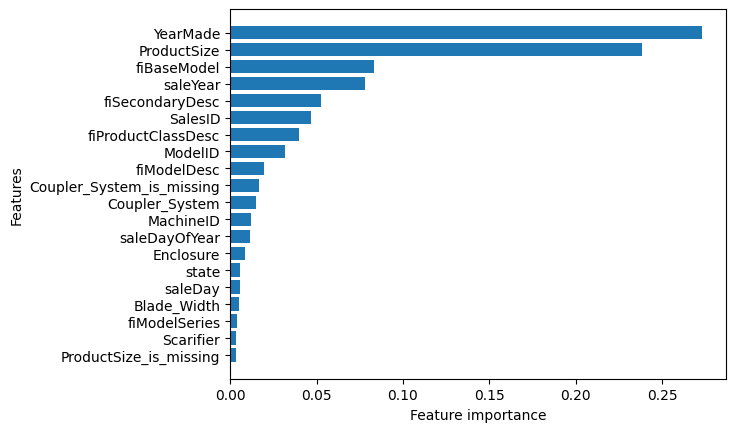

In [55]:
plot_features(x_train.columns, ideal_model.feature_importances_)